In [0]:
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
!unzip '/content/drive/My Drive/applied ai/datasets/18_2157_compressed_database.sqlite.zip'

Archive:  /content/drive/My Drive/applied ai/datasets/18_2157_compressed_database.sqlite.zip
  inflating: database.sqlite         


In [0]:
con = sqlite3.connect('/content/database.sqlite') 

In [0]:

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

In [0]:
def partition(x):
  if x < 3:
    return 0
  return 1

actualscore=filtered_data['Score']
PN=actualscore.map(partition)
filtered_data['Score']=PN

In [6]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data.shape

(5000, 10)

In [0]:
display=pd.read_sql_query("""
SELECT ProductID,UserID,ProfileName,Score,Time,Text,COUNT(*) FROM REVIEWS
GROUP BY UserID HAVING
 COUNT(*)>1""",con)

In [9]:
display.shape

(80668, 7)

In [10]:
display

,ProductId,UserId,ProfileName,Score,Time,Text,COUNT(*)
0,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,1331510400,Overall its just OK when considering the price...,2
1,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",5,1342396800,"My wife has recurring extreme muscle spasms, u...",3
2,B007Y59HVM,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,1,1348531200,This coffee is horrible and unfortunately not ...,2
3,B005HG9ET0,#oc-R11O5J5ZVQE25C,Penguin Chick,5,1346889600,This will be the bottle that you grab from the...,3
4,B007OSBE1U,#oc-R12KPBODL2B5ZD,Christopher P. Presta,1,1348617600,I didnt like this coffee. Instead of telling y...,2
...,...,...,...,...,...,...,...
80663,B0039GMZZK,AZZNK89PXD006,Etude,5,1269648000,Regular Chocolate Pocky is good on its own but...,6
80664,B003Z4F56C,AZZTH6DJ0KSIP,Crystal Caccamo,5,1337558400,i eat paleo so noodles are not allowed. i trie...,3
80665,B003FDG4K4,AZZU1VEO8KUXH,"Mia P ""Mia P""",5,1317513600,I bought this for my 13 year old daughter who ...,3
80666,B0029XEXZE,AZZU4D6TZ2L6J,"Sherry King ""llamasmama""",5,1247875200,My father thought this was the best cheese eve...,2


In [11]:
pd.read_sql_query("""SELECT * FROM REVIEWS where UserID='#oc-R115TNMSPFT9I7' """,con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
1,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...


single user gave same review at the same time to multiple product

Its a kind of error so,remove duplicates

In [0]:
#sort producrt Id in ascending order
sorteddata=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final_data=sorteddata.drop_duplicates(subset={'UserId',"ProfileName","Time","Text"},keep='first',inplace=False)

In [14]:
final_data.shape

(4986, 10)

In [15]:
pd.read_sql_query("""select * from REVIEWS where HelpfulnessNumerator > HelpfulnessDenominator""",con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


HelpfullnessNumerator should be less than denominator 

Numerator is all the people who said "Yes this is helpfull review"

Denominator is people who said " YES+NO this is not helpfull"

In [0]:
#Only keep those whose numearator is <denominator
final_data=final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]

In [17]:
final_data.shape

(4986, 10)

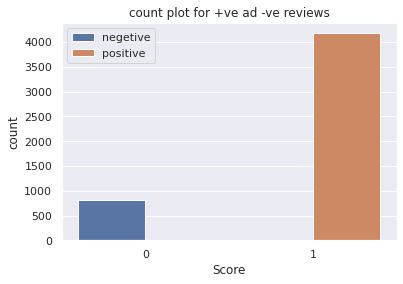

1    4178
0     808
Name: Score, dtype: int64

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
sns.countplot(x="Score",hue='Score',data=final_data)
plt.legend(['negetive','positive'])
plt.title('count plot for +ve ad -ve reviews')
plt.show()
final_data['Score'].value_counts()

In [0]:
count_vec=CountVectorizer()
final_counts=count_vec.fit_transform(final_data['Text'].values)

In [20]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [21]:
final_counts.get_shape

<bound method spmatrix.get_shape of <4986x13510 sparse matrix of type '<class 'numpy.int64'>'
	with 253517 stored elements in Compressed Sparse Row format>>

In [22]:
print(final_counts[0,:])

  (0, 13215)	1
  (0, 6466)	2
  (0, 12122)	1
  (0, 13169)	1
  (0, 12060)	2
  (0, 10349)	1
  (0, 9316)	1
  (0, 1102)	1
  (0, 4991)	1
  (0, 5845)	1
  (0, 1759)	3
  (0, 6029)	1
  (0, 13381)	1
  (0, 740)	1
  (0, 2691)	1
  (0, 12894)	2
  (0, 4948)	2
  (0, 7253)	1
  (0, 1290)	1
  (0, 9777)	1
  (0, 3951)	1
  (0, 1142)	1
  (0, 7219)	1
  (0, 788)	1
  (0, 7220)	1
  (0, 12374)	1
  (0, 925)	1
  (0, 12675)	1
  (0, 8254)	1
  (0, 3078)	1
  (0, 12304)	1
  (0, 5254)	1
  (0, 9236)	1
  (0, 11435)	1
  (0, 1975)	1
  (0, 8316)	1
  (0, 10116)	1
  (0, 7985)	1


In [23]:
review1 = final_data['Text'].values[0]
print(review1)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In the reviews we have extra and unwanted tags like html tags,pulstops ,commas etc so we hav eto remove those kind of tags

In [24]:
#removing that html tag
review1=re.sub(r"http:\S+"," ",review1)
print(review1)

Why is this $[...] when the same product is available for $[...] here?<br />  /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [25]:
# we have to remove xml tags
from bs4 import BeautifulSoup
soup=BeautifulSoup(review1,'lxml')
text=soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here?  />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#we have to redeclare the phraces which is pronounceed like i'll=i will

def decontracted(phrase):
  #specific
  phrase = re.sub(r"won't","will not",phrase )
  phrase =re.sub(r"can't","can not",phrase)

  #general
  phrase = re.sub(r"n\'t","not",phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

In [27]:
review1500=final_data['Text'].values[1500]
print(review1500)
print('='*50)
review1500=decontracted(review1500)
print(review1500)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you don't like that combination, don't order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let's also remember that tastes differ; so, I've given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I don't see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They aren't individually wrapped, which would add to the cost.  Oh yeah, cho

In [28]:

review150=final_data['Text'].values[150]
print(review1500)
print('='*50)

review4900=final_data['Text'].values[4900]
print(review1500)
print('='*50)

review1000=final_data['Text'].values[1000]
print(review1500)
print('='*50)


Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you donot like that combination, donot order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I donot see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They arenot individually wrapped, which would add to the cost.  Oh yeah,

In [29]:
#remove words with numbers

review1=re.sub(r"\S*\d\S*","",review1)
print(review1)

Why is this $[...] when the same product is available for $[...] here?<br />  /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [30]:
# remove special characters
review1500=re.sub(r"[^A-Za-z0-9]+",' ',review1500)
print(review1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you donot like that combination donot order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I donot see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They arenot individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you want s

In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [32]:
#preforming all the above operations to the whole data
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


100%|██████████| 4986/4986 [00:02<00:00, 2397.48it/s]


In [33]:
preprocessed_reviews[500]

'good snack feel great offering month old easily pick small pieces definitely enjoys apple cinnamon taste year old loves well would definitely recommend anyone small larger kids'

In [34]:
count_vec=CountVectorizer()
count_vec.fit(preprocessed_reviews)
print('some feature names ',count_vec.get_feature_names()[:10])
print('='*50)

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']


In [35]:
preprocessed_reviews[9]

'description product disceptive product represented powder not powder granule nothing shredded coconut doesnot even dissolve high speed commercial blender unless using product manufacture dark chocolate coated coconut patty useless intention use additive healthy shake ended ruining shake resort chewing undissolved tasteless coconut pieces rather drinking shake additionally way product packaged no protective cardboard preventing slashing top package box opened could rated product zero stars would redeeming quality rather inexpensive gave one package away free patient loves coconut gave back two days later complaining terrible'

In [36]:
import string

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import  WordNetLemmatizer

sno=nltk.SnowballStemmer('english')

print(sno.stem('tasty'))

tasti


In [37]:
print (sno.stem('tasts'))

tast


In [38]:
import nltk
nltk.download('stopwords')

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,' ',sentence)
  return cleantext

def cleanpun(sentence):
  celaned = re.sub(r'[?|!|\'|*|#]',r'',sentence)
  cleaned= re.sub(r'[.|,|)|(|\|/]',r'',sentence)
  return cleaned

print(stop)
print('*'*50)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'hasn', 'these', 'hers', 'and', 'it', 'this', 'who', "you've", 'your', 'being', 'through', "that'll", "aren't", 'because', 'needn', "mightn't", "mustn't", 'off', 'didn', 'what', 'most', 'were', 'have', 's', 'wouldn', 'once', "weren't", 'into', 'yourselves', 'be', "hadn't", 'the', 'where', 've', 'down', 'she', 'isn', 'just', 'from', 'we', 'against', 'do', 'how', 'mightn', 'ours', 'whom', 'doesn', "doesn't", 'ain', 'are', "you'll", "you're", 'up', 'will', "wasn't", 'until', 'a', "needn't", 't', 'you', 'then', "she's", 'himself', "couldn't", "should've", 'had', 'in', 'my', "didn't", 'if', 'why', 'not', 'wasn', 'was', 'is', 'weren', 'over', "won't", 'other', 'same', 'its', 'their', 'but', 'below', 'd', 'should', 'or', "it's", 'both', 'can', 'his', "haven't", 'nor', 'll', 'theirs', 'those', 'i', 'an', 'won', 'shouldn', 'at', 'been', 'has', 'ma', 'yours', 'as', 'her', 'don', 'hadn'

In [0]:
i=0
str1=''
final_string=[]
all_positive=[]
all_negetive=[]
s=''

for sent in final_data['Text'].values:
  filtered_sentence=[]
  sent=cleanhtml(sent)
  for w in sent.split():
    for cleaned_words in cleanpun(w).split():
      if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
        if (cleaned_words.lower() not in stop):
          s=(sno.stem(cleaned_words.lower())).encode('utf8')
          filtered_sentence.append(s)
          if(final_data['Score'].values)[i] == 1:
            all_positive.append(s)
          if(final_data['Score'].values)[i] == 0:
            all_negetive.append(s)
      
      else:
        continue
    else:
      continue

  str1= b" ".join(filtered_sentence)

  final_string.append(str1)
  i+=1
    

In [0]:
#adding new column

final_data['CleanedText']=final_string

In [41]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,b'product avail victor trap unreal cours total...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,b'use victor fli bait season beat great'
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,b'glad cockerstandard poodl puppi love stuff t...


In [0]:
#storing  final proprocessed data into sql

conn=sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews',conn,schema=None,if_exists='replace')

In [43]:
freq_dist_positive = nltk.FreqDist(all_positive)
freq_dist_negetive= nltk.FreqDist(all_negetive)

print("Most common positive Words",freq_dist_positive.most_common(20))
print("Most common negetive Words",freq_dist_negetive.most_common(20))

Most common positive Words [(b'like', 1804), (b'tast', 1609), (b'flavor', 1497), (b'good', 1496), (b'love', 1450), (b'great', 1366), (b'use', 1265), (b'one', 1173), (b'product', 1145), (b'tri', 1145), (b'coffe', 990), (b'make', 978), (b'food', 977), (b'chip', 955), (b'get', 826), (b'tea', 776), (b'bag', 736), (b'buy', 716), (b'eat', 698), (b'would', 695)]
Most common negetive Words [(b'like', 441), (b'tast', 421), (b'product', 387), (b'tri', 282), (b'one', 277), (b'flavor', 255), (b'would', 246), (b'food', 231), (b'use', 224), (b'good', 197), (b'buy', 185), (b'order', 182), (b'get', 178), (b'chip', 178), (b'tea', 177), (b'bag', 175), (b'even', 168), (b'make', 161), (b'box', 154), (b'eat', 152)]


In [0]:
count_vec=CountVectorizer(ngram_range=(1,2))
final_bigarm_counts = count_vec.fit_transform(final_data['Text'].values)

In [45]:
final_bigarm_counts.get_shape()

(4986, 148211)

In [46]:
#Before Bigram
final_counts.shape

(4986, 13510)

In [0]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec= TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_idf_vec.fit_transform(final_data['Text'].values)

In [48]:
final_tf_idf.get_shape()

(4986, 148211)

In [49]:
features = tf_idf_vec.get_feature_names()
len(features)

148211

In [50]:
features[100000:100010]

['product actually',
 'product add',
 'product added',
 'product advertises',
 'product after',
 'product again',
 'product all',
 'product allows',
 'product almost',
 'product also']

In [51]:
#convert a roe into sparse matrix to numpy array
print(final_tf_idf[1,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [0]:
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [53]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9968652725219727), ('especially', 0.9964615702629089), ('amazing', 0.996401846408844), ('grey', 0.9963382482528687), ('overall', 0.9963001608848572), ('chewy', 0.996292233467102), ('tender', 0.9962608218193054), ('alternative', 0.9962392449378967), ('salsa', 0.9961856007575989), ('crispy', 0.9959666728973389)]
[('remember', 0.9993783235549927), ('pods', 0.9993764162063599), ('totally', 0.9993599057197571), ('type', 0.9993300437927246), ('special', 0.9992913007736206), ('wow', 0.9992794990539551), ('simply', 0.999275267124176), ('similar', 0.9992696046829224), ('part', 0.9992631077766418), ('enjoyed', 0.9992589950561523)]
